# Modeling Sublimation Event Occurrence

Written by: Daniel Hogan

10 April 2025

It's raining outside with a weak AR-like event impacting northern VI

This notebook will develop, test, and validate a few different model strategies to classify when sublimation events occur using ERA5 reanalysis data.

In [1]:
# general
import datetime as dt
import glob
# data 
import xarray as xr 
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.basemap import Basemap
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from PIL import Image
from matplotlib.animation import PillowWriter, FFMpegWriter
# helper tools
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

### Stats packages 

In [2]:
# stats
import seaborn as sns
import shapely.geometry as shp
from itertools import product
from scipy.stats import pearsonr, spearmanr

# Functions

In [87]:
def calc_valley_aligned_wind_speed(wind_speed, wind_dir, valley_alignment):
    """
    Calculate the valley aligned wind speed
    """
    # calculate the angle between the wind direction and the valley alignment
    angle = np.abs(wind_dir - valley_alignment)
    # calculate the valley aligned wind speed
    valley_aligned_wind_speed = wind_speed * np.cos(np.radians(angle))
    return valley_aligned_wind_speed

def subset_ds(ds, winter_slice, location, cross_valley_orientation, valley_orientation):
    """
    Subset the dataset to the winter months
    """
    # subset the data   
    ds_subset = ds.sel(valid_time=winter_slice)
    if location is None:
        ds_subset = ds_subset.mean(dim=['latitude', 'longitude']).compute()
    else:
        ds_subset = ds_subset.sel(latitude=location.y, longitude=location.x, method='nearest').compute()

    # calculate the wind speed and direction
    ds_subset['wind_speed'] = np.sqrt(ds_subset.u**2 + ds_subset.v**2)
    # create a column with the wind direction
    ds_subset['wind_dir'] = np.arctan2(ds_subset['v'], ds_subset['u']) * 180 / np.pi
    # convert wind direction to compass direction
    ds_subset['wind_dir'] = (270 - ds_subset['wind_dir']) % 360

    # calculate "northerliness"
    ds_subset['northerliness'] = np.cos(np.deg2rad(ds_subset['wind_dir']))
    
    # calculate dew point from relative humidity and temeprature
    # convert temperature to celsius
    ds_subset['t'] = units.units('degC') * (ds_subset['t']-273.15)
    return ds_subset

def select_data(lh_df, ppt_data, reanalysis_ds, short_events, long_events):
    """
    This function will provide the necessary data for the analysis of sublimation events in relation to the reanalysis data.
    """
    # resample latent heat flux data and precipitation data to 3H
    lh_df_3H = lh_df.resample('3H').mean()
    ppt_data_3H = ppt_data.resample('3H').sum()
    #   filter out exrtreme values
    lh_df_3H = lh_df_3H.where(lh_df_3H >-50, np.nan)
    # select the reanalysis pressure level
    ds = reanalysis_ds.sel(pressure_level=500).resample(valid_time='3H').mean()

    return lh_df_3H, ppt_data_3H, ds, short_events, long_events


In [88]:
def find_best_synoptic_variable(surface_obs, synoptic_data, method='pearson'):
    """
    Finds the synoptic-scale variable that is most closely related to a given surface meteorology observation.

    Parameters:
    - surface_obs (pd.Series): Time series of the surface meteorology variable (e.g., temperature, humidity).
    - synoptic_data (pd.DataFrame): Time series of synoptic-scale variables (e.g., geopotential height, wind speed).
    - method (str): Correlation method ('pearson' for linear, 'spearman' for rank-based). Default is 'pearson'.

    Returns:
    - dict: Contains the best-correlated variable, its correlation coefficient, and the full correlation results.
    """
    
    correlations = {}

    for var in synoptic_data.columns:
        synoptic_var = synoptic_data[var]

        # Drop NaN values
        valid_idx = surface_obs.index.intersection(synoptic_var.dropna().index)
        x = surface_obs.loc[valid_idx]
        y = synoptic_var.loc[valid_idx]

        if len(x) < 10:  # Require a minimum number of valid data points
            continue

        # Compute correlation
        if method == 'pearson':
            corr, _ = pearsonr(x, y)
        elif method == 'spearman':
            corr, _ = spearmanr(x, y)
        else:
            raise ValueError("Invalid method. Choose 'pearson' or 'spearman'.")

        correlations[var] = corr

    # Find the variable with the highest absolute correlation
    best_var = max(correlations, key=lambda k: abs(correlations[k]))
    
    return {
        'best_variable': best_var,
        'best_correlation': correlations[best_var],
        'all_correlations': correlations
    }


In [5]:
def compute_cross_correlation(df, target_var, lag_range=(-10, 10)):
    """
    Compute cross-correlations between a target variable and other variables with different time lags.

    Parameters:
    - df: pandas DataFrame with time-indexed meteorological variables.
    - target_var: Name of the target variable (e.g., "sublimation").
    - lag_range: Tuple specifying min and max lag (e.g., (-10, 10)).

    Returns:
    - A DataFrame containing cross-correlations for each lag.
    """
    variables = df.columns.drop(target_var)  # Exclude the target variable itself
    lag_values = range(lag_range[0], lag_range[1] + 1)

    correlation_results = pd.DataFrame(index=lag_values, columns=variables)

    for lag in lag_values:
        shifted_target = df[target_var].shift(lag)  # Shift target variable
        correlation_results.loc[lag] = df[variables].corrwith(shifted_target)

    return correlation_results.astype(float)

In [89]:
# Plotting 
def plot_surface_and_reanalysis_vars(lh_df, ppt_data, era5_ds, short_events, long_events, lh_var, reanalysis_var1, reanalysis_var2):
    """
    This function will plot the relationship between the latent heat flux and the reanalysis variables.
    Inputs:
    lh_df: DataFrame with the latent heat flux data
    ppt_data: DataFrame with the precipitation data
    era5_ds: xarray dataset with the reanalysis data
    short_events: DataFrame with the short, intense sublimation events
    long_events: DataFrame with the long sublimation events
    lh_var: string with the name of the latent heat flux variable
    reanalysis_var1: string with the name of the first reanalysis variable
    reanalysis_var2: string with the name of the second reanalysis variable
    """
    lh_df, ppt_data, era5_ds, short_events, long_events = select_data(lh_df, ppt_data, era5_ds, short_events, long_events)

    xlabel_dict = {'u': 'Wind Speed (m/s)', 
                   'v': 'Wind Speed (m/s)', 
                   't': 'Temperature (C)', 
                   'q': 'Specifc Humidity (kg/kg)', 
                   'wind_speed': 'Wind Speed (m/s)', 
                   'wind_dir': 'Wind Direction (degrees)',
                   'northerliness': 'Index of how northerly wind is (+1 strong north wind, -1 strong south wind)',
                   }
    xlims_dict = {
             'q': (0, 0.0035),
             't': (-40, -5),}
             
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axs[0]
    ax.scatter(era5_ds[reanalysis_var1], lh_df[lh_var])
    # ax.set_xlabel('Wind Speed')
    ax.set_ylabel('Daily Average Latent Heat Flux (W/m^2)')
    if reanalysis_var1 in xlims_dict.keys():
            ax.set_xlim(xlims_dict[reanalysis_var1])

    # add edge color around the large sublimation events 
    ax.scatter(era5_ds.sel(valid_time=long_events.index)[reanalysis_var1], lh_df.loc[long_events.index][lh_var], c="black", edgecolors='black')
    ax.scatter(era5_ds.sel(valid_time=ppt_data[ppt_data>1].index)[reanalysis_var1], lh_df.loc[ppt_data[ppt_data>1].index][lh_var], c="red", edgecolors='red', label='Precipitation')
    ax.set_xlabel(xlabel_dict[reanalysis_var1])
    ax.axvline(28, color='black', linestyle='--')
    
    ax = axs[1]
    ax.scatter(era5_ds[reanalysis_var2], lh_df[lh_var])
    ax.scatter(era5_ds.sel(valid_time=long_events.index)[reanalysis_var2], lh_df.loc[long_events.index][lh_var], c="black", edgecolors='black', label='Long Events')
    ax.axvline(33, color='black', linestyle='--')
    ax.scatter(era5_ds.sel(valid_time=ppt_data[ppt_data>1].index)[reanalysis_var2], lh_df.loc[ppt_data[ppt_data>1].index][lh_var], c="red", edgecolors='red', label='Precipitation')
    ax.set_xlabel(xlabel_dict[reanalysis_var2])
    ax.set_ylabel('Daily Average Latent Heat Flux (W/m^2)')
    ax.legend()
    if reanalysis_var2 in xlims_dict.keys():
            ax.set_xlim(xlims_dict[reanalysis_var2])
    # add colorbar
    # plt.colorbar(ax.collections[0], ax=axs, orientation='horizontal', label='500 mb Temperature (C)')

    for ax in axs:
        ax.set_ylim(-10, lh_df[lh_var].max()+10)
    return fig

# Load the data

## ERA5 data

In [268]:
ds = xr.open_mfdataset('/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_202*.nc')
# latitude=slice(42, 36), longitude=slice(-110, -104)
lat_sel = slice(41,37)
lon_sel = slice(-111,-106)
ds = ds.sel(latitude=lat_sel, longitude=lon_sel)


In [170]:
winter_2022 = slice('2021-12-01T00:00:00', '2022-03-31T23:00:00')
winter_2023 = slice('2022-12-01T00:00:00', '2023-03-31T23:00:00')

# geographic data and orietation of the valley
valley_orientation = 305
cross_valley_orientation = 215
# get the coordingates of Grand Junction, CO
gj = shp.Point(-108.5506, 39.0639)
# get the coordinates of Gothic, CO
gothic = shp.Point(-106.9898, 38.9592)
line = shp.LineString([gj, gothic])

ds_gt_winter_2022 = subset_ds(ds, winter_2022, location=gothic, cross_valley_orientation=cross_valley_orientation, valley_orientation=valley_orientation)
ds_gt_winter_2023 = subset_ds(ds, winter_2023, location=gothic, cross_valley_orientation=cross_valley_orientation, valley_orientation=valley_orientation)

ds_all_winter_2022 = subset_ds(ds, winter_2022, location=None, cross_valley_orientation=cross_valley_orientation, valley_orientation=valley_orientation)
ds_all_winter_2023 = subset_ds(ds, winter_2023, location=None, cross_valley_orientation=cross_valley_orientation, valley_orientation=valley_orientation)

ds.close()

## Latent heat flux data

In [171]:
# take in sublimation data
latent_heat_flux_2022 = pd.read_csv('./01_data/processed_data/sublimation/w22_latent_heat_flux_splash_ap.csv', index_col=0, parse_dates=True)
latent_heat_flux_2023 = pd.read_csv('./01_data/processed_data/sublimation/w23_latent_heat_flux_3m.csv', index_col=0, parse_dates=True)

## Event classifications

In [172]:
# open large and spiky events dataset 
w22_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
w22_large_sublimation_spiky_events = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)
w23_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
w23_large_sublimation_spiky_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)

## Precipitation data (from Gothic weighing bucket)

In [173]:
# open precipitation data
w22_precipitation = pd.read_csv('./01_data/processed_data/precipitation/w22_all_precip_30min.csv', index_col=0, parse_dates=True)['SAIL_gts_pluvio'].loc['2021-12-01':'2022-03-31']
w23_precipitation = pd.read_csv('./01_data/processed_data/precipitation/w23_all_precip_30min.csv', index_col=0, parse_dates=True)['SAIL_gts_pluvio'].loc['2022-12-01':'2023-03-31']

## Merge the data

In [174]:
# merge the two datasets
if 'splash_ap' in latent_heat_flux_2022.columns:
    latent_heat_flux_2022.rename(columns={'splash_ap': 'sublimation'}, inplace=True)
if 'sos_3m' in latent_heat_flux_2023.columns:
    latent_heat_flux_2023.rename(columns={'sos_3m': 'sublimation'}, inplace=True)
latent_heat_flux = pd.concat([latent_heat_flux_2022, latent_heat_flux_2023], axis=0)

# merge the two datasets
reanalysis_df = xr.merge([ds_all_winter_2022, ds_all_winter_2023]).sel(pressure_level=500)

# calculate vapor pressure deficit
reanalysis_df['vpd'] = calc.saturation_vapor_pressure((reanalysis_df['t'])) - reanalysis_df['q'] * units.units('Pa')

reanalysis_df = reanalysis_df.to_dataframe()[['u','v', 'q','t','vpd','vo','wind_speed','northerliness']]

# add precipitation
precip_df = pd.concat([w22_precipitation, w23_precipitation], axis=0).resample('3H').sum()

# add precipitation to the reanalysis dataframe
reanalysis_df['precipitation'] = precip_df

combined_df = pd.merge(latent_heat_flux, reanalysis_df, left_index=True, right_index=True).resample('3H').mean()

# add event column
combined_df['event'] = 0
combined_df.loc[w22_large_sublimation_long_events.index, 'event'] = 1
# combined_df.loc[w22_large_sublimation_spiky_events.index, 'event'] = 1
combined_df.loc[w23_large_sublimation_long_events.index[:-1], 'event'] = 1
# combined_df.loc[w23_large_sublimation_spiky_events.index, 'event'] = 1

resample = True
if resample:
    # resample the data to 12H
    combined_df_12H = combined_df.resample('12H').agg({'sublimation': 'sum', 
                                                'u': 'mean', 
                                                'v': 'mean', 
                                                't': 'mean',
                                                'vo': 'mean', 
                                                'q' : 'min',
                                                'vpd': 'min',
                                                'wind_speed': 'max', 
                                                'precipitation':'sum',
                                                'northerliness': 'median', 
                                                'event': 'max'})

# reset the index and dropna
combined_df = combined_df.reset_index()

# replace event values equal to 0 with "non-event" and 1 with "event"
combined_df['event'] = combined_df['event'].replace({0: 'non-event', 1: 'event'})

# Basic Statistics

## 2022

In [175]:
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2022, 
                                                                  w22_precipitation, 
                                                                  ds_gt_winter_2022, 
                                                                  w22_large_sublimation_spiky_events, 
                                                                  w22_large_sublimation_long_events,)

In [176]:
# largest_events = (long_events.groupby('event').mean() > 15)
synoptic_data = era5_ds.to_dataframe()[['q','t','u','v','vo','wind_speed','northerliness']].loc[[t[0] for t in long_events.groupby('event').idxmax().values]]
surface_obs = long_events.groupby('event').max().set_index(synoptic_data.index).splash_ap

result = find_best_synoptic_variable(surface_obs, synoptic_data, method='spearman')

print("Best correlated synoptic variable:", result['best_variable'])
print("Correlation coefficient:", result['all_correlations'])

Best correlated synoptic variable: wind_speed
Correlation coefficient: {'q': -0.44545454545454555, 't': -0.09090909090909091, 'u': -0.02727272727272728, 'v': -0.5090909090909091, 'vo': -0.3272727272727273, 'wind_speed': 0.5818181818181819, 'northerliness': 0.08181818181818183}


In [177]:
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2022, w22_precipitation, ds_all_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events,)

In [178]:
# largest_events = (long_events.groupby('event').mean() > 15)
synoptic_data = era5_ds.to_dataframe()[['q','t','u','v','vo','wind_speed','northerliness']].loc[[t[0] for t in long_events.groupby('event').idxmax().values]]
surface_obs = long_events.groupby('event').max().set_index(synoptic_data.index).splash_ap

result = find_best_synoptic_variable(surface_obs, synoptic_data, method='spearman')

print("Best correlated synoptic variable:", result['best_variable'])
print("Correlation coefficient:", result['all_correlations'])

Best correlated synoptic variable: v
Correlation coefficient: {'q': -0.3090909090909091, 't': 0.13636363636363638, 'u': -0.08181818181818183, 'v': -0.5454545454545455, 'vo': -0.5090909090909091, 'wind_speed': 0.5090909090909091, 'northerliness': 0.18181818181818182}


We averaged the synoptic level (500 mb) data in two differnt ways: the average of a 10x10 ERA5 grid centered over the East River valley and the nearest grid cell over Gothic. We took this data and calculated spearman correlations with the maximum surface latent heat flux observation during long events. 

We found that both the single grid cell and the regional average both correlate well with u-wind and wind-speed. However, large differences are observed for temperature (> for single grid cell), vorticity (> for grid-average)

This likely means that including certain variables may not be super helpful. This is only for the 2023 data.

We get a pretty different story during 2022. For the gridded average, v, q, and t have the largest relationships, with wind speed being much lower. This might be why including these other variables prove to be useful within the model. It seems q, t, u, v, and vo are the most useful. 

## Percentile rank and cross-correlation figures

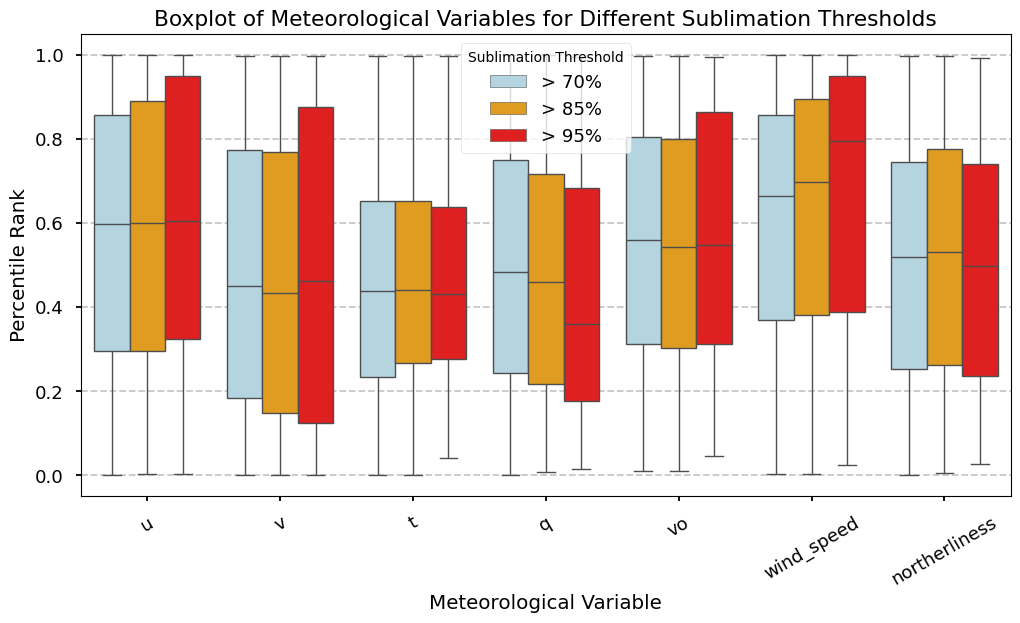

In [179]:
# Calculate percentiles
percentiles = combined_df.rank(method="average", pct=True)[['northerliness','t', 'q', 'vo', 'wind_speed', 'sublimation', 'u', 'v']]

# Subset for different sublimation thresholds
percentiles_sub_50 = percentiles[percentiles['sublimation'] > 0.75]
percentiles_sub_75 = percentiles[percentiles['sublimation'] > 0.85]
percentiles_sub_95 = percentiles[percentiles['sublimation'] > 0.95]

# Drop 'sublimation' since it's the target variable
variables = ['u','v', 't', 'q', 'vo', 'wind_speed', 'northerliness']

# Create a grouped DataFrame for boxplot
melted_50 = percentiles_sub_50[variables].melt(var_name="Variable", value_name="Percentile")
melted_50["Threshold"] = "> 70%"

melted_75 = percentiles_sub_75[variables].melt(var_name="Variable", value_name="Percentile")
melted_75["Threshold"] = "> 85%"

melted_95 = percentiles_sub_95[variables].melt(var_name="Variable", value_name="Percentile")
melted_95["Threshold"] = "> 95%"

# Combine into a single dataframe
plot_data = pd.concat([melted_50, melted_75, melted_95])

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variable", y="Percentile", hue="Threshold", data=plot_data, palette=["lightblue", "orange", "red"])

# Customization
plt.title("Boxplot of Meteorological Variables for Different Sublimation Thresholds")
plt.xlabel("Meteorological Variable")
plt.ylabel("Percentile Rank")
plt.legend(title="Sublimation Threshold", loc='upper center')
plt.xticks(rotation=30)  # Rotate x labels for better readability

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


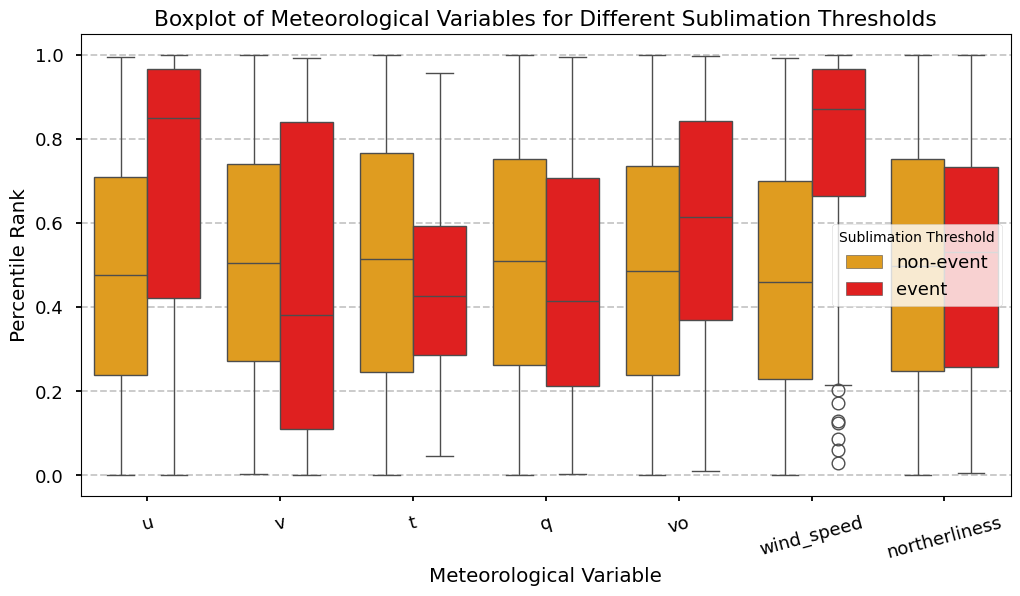

In [180]:
# Calculate percentiles
percentiles = combined_df.rank(method="average", pct=True)[['u', 'v','t', 'q', 'vo', 'wind_speed', 'sublimation', 'northerliness']]

# Subset for different sublimation thresholds
percentiles_event = percentiles[combined_df['event']=='event']
percentiles_non_event = percentiles[combined_df['event']=='non-event']

# Drop 'sublimation' since it's the target variable
variables = ['u','v','t', 'q', 'vo', 'wind_speed','northerliness']

# Create a grouped DataFrame for boxplot
melted_non_event = percentiles_non_event[variables].melt(var_name="Variable", value_name="Percentile")
melted_non_event["Threshold"] = "non-event"

melted_event = percentiles_event[variables].melt(var_name="Variable", value_name="Percentile")
melted_event["Threshold"] = "event"

# Combine into a single dataframe
plot_data = pd.concat([melted_non_event, melted_event]).reset_index(drop=True)

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variable", y="Percentile", hue="Threshold", data=plot_data, palette=["orange", "red"])

# Customization
plt.title("Boxplot of Meteorological Variables for Different Sublimation Thresholds")
plt.xlabel("Meteorological Variable")
plt.ylabel("Percentile Rank")
plt.legend(title="Sublimation Threshold")
plt.xticks(rotation=15)  # Rotate x labels for better readability

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


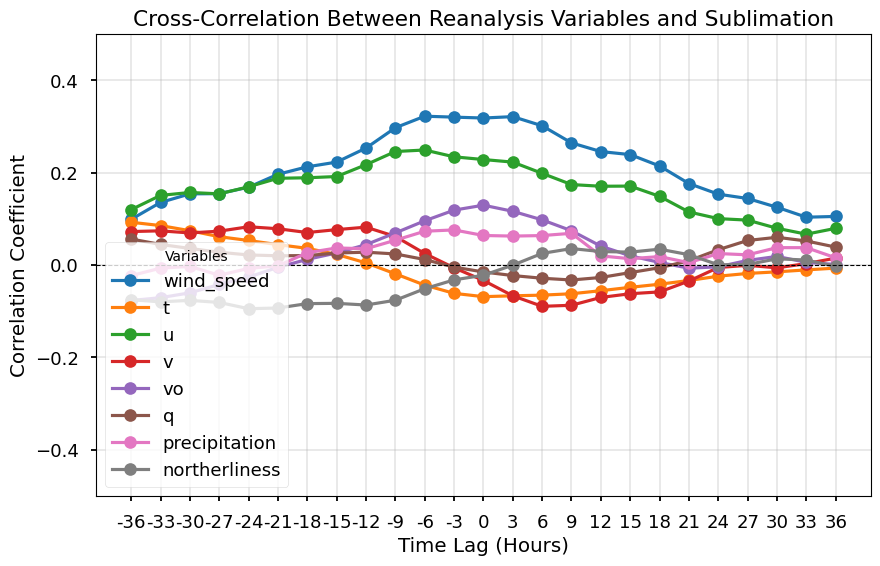

In [181]:
# Example usage
cross_corrs = compute_cross_correlation(combined_df[['wind_speed', 't', 'u', 'v', 'vo', 'sublimation', 'q', 'precipitation','northerliness']], target_var='sublimation', lag_range=(-12, 12))

# Plot correlation results
plt.figure(figsize=(10, 6))
for var in cross_corrs.columns:
    plt.plot(cross_corrs.index, cross_corrs[var], label=var, marker='o', linestyle='-')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Reference line at 0
# change out the x-axis for hours by multiplying by 3
plt.xticks(np.arange(-12, 13, 1), labels=np.arange(-12, 13, 1)*3)
plt.xlabel("Time Lag (Hours)")
plt.ylabel("Correlation Coefficient")
plt.title("Cross-Correlation Between Reanalysis Variables and Sublimation")
plt.legend(title="Variables")
plt.grid(alpha=0.3)
plt.ylim(-0.5,0.5)
plt.show()


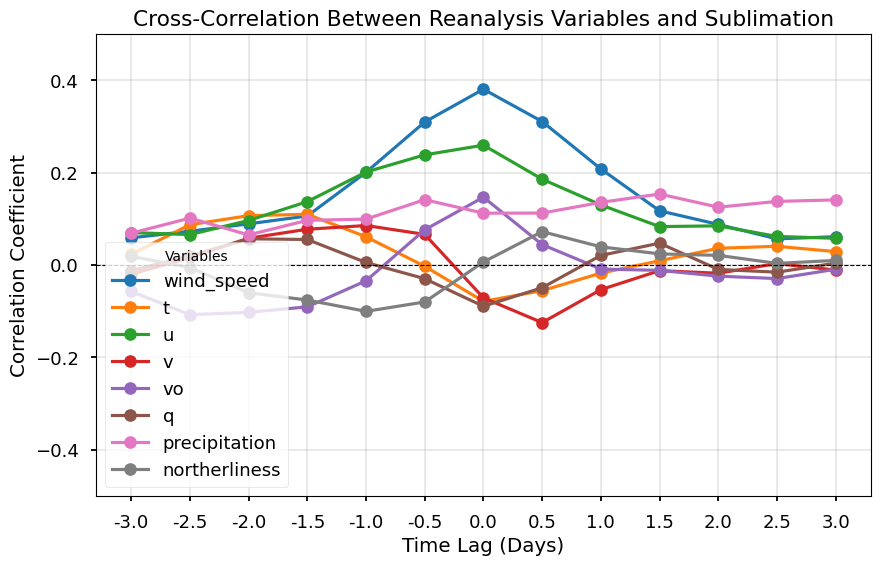

In [182]:
# Example usage
cross_corrs = compute_cross_correlation(combined_df_12H[['wind_speed', 't', 'u', 'v', 'vo', 'sublimation', 'q', 'precipitation', 'northerliness']], 
                                        target_var='sublimation', 
                                        lag_range=(-6, 6))

# Plot correlation results
plt.figure(figsize=(10, 6))
for var in cross_corrs.columns:
    plt.plot(cross_corrs.index, cross_corrs[var], label=var, marker='o', linestyle='-')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Reference line at 0
# change out the x-axis for hours by multiplying by 3
plt.xticks(np.arange(-6, 7, 1), labels=np.arange(-6, 7, 1)/2)
plt.xlabel("Time Lag (Days)")
plt.ylabel("Correlation Coefficient")
plt.title("Cross-Correlation Between Reanalysis Variables and Sublimation")
plt.legend(title="Variables")
plt.grid(alpha=0.3)
plt.ylim(-0.5,0.5)
plt.show()


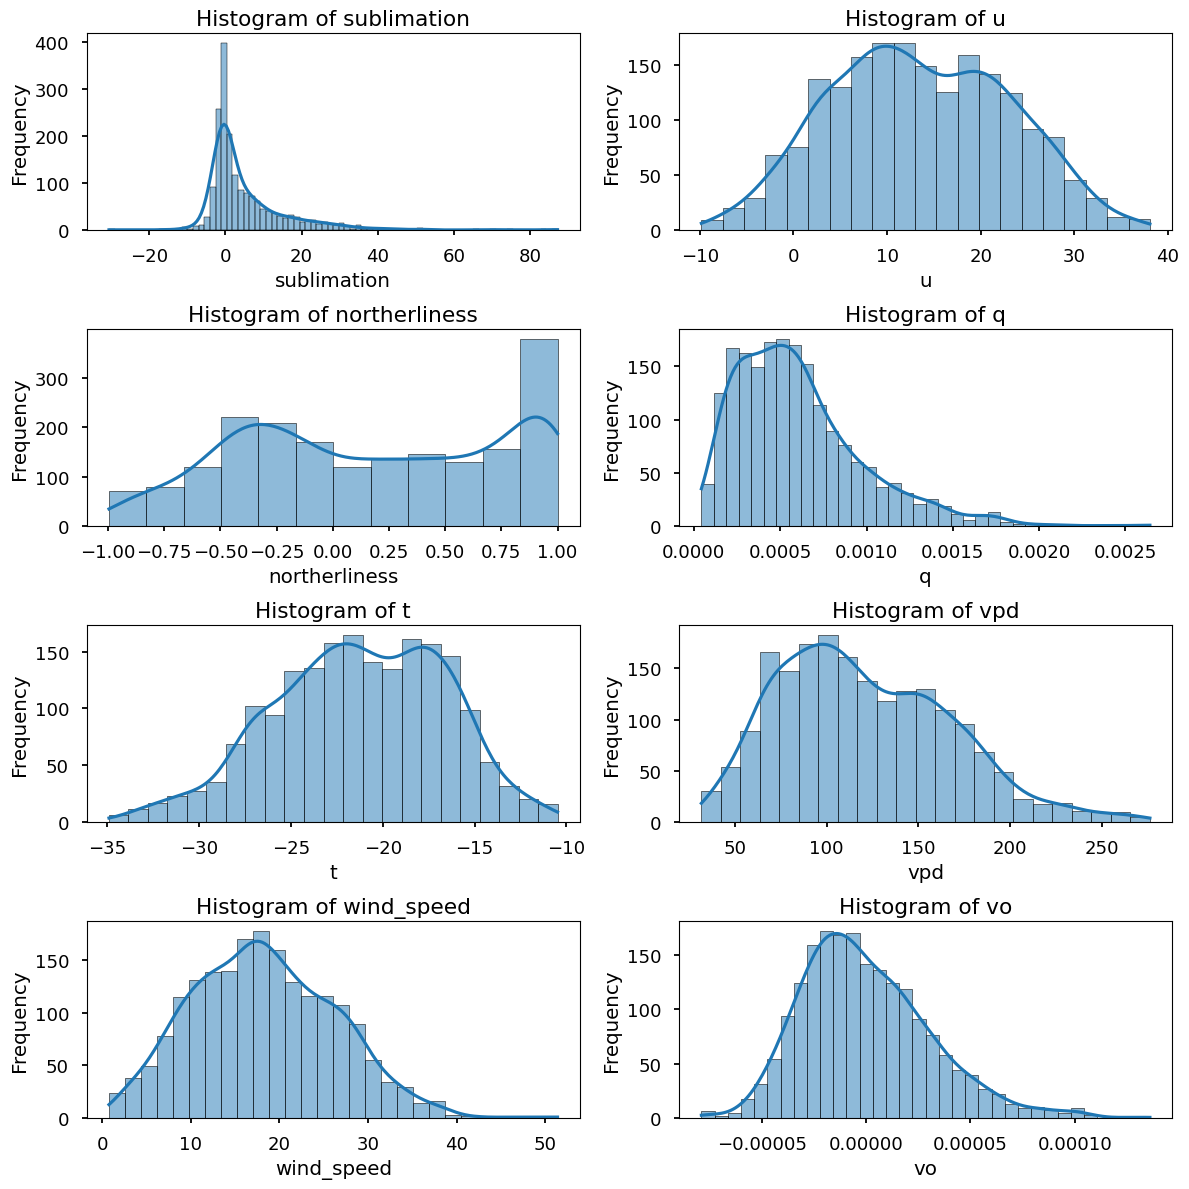

In [183]:
vars_to_plot = ['sublimation', 'u', 'northerliness', 'q', 't', 'vpd', 'wind_speed', 'vo',]

# plot histograms of each variable in vars_to_plot
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
for ax, var in zip(axs.flat, vars_to_plot):
    sns.histplot(combined_df[var], ax=ax, kde=True)
    ax.set_title(f"Histogram of {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
plt.tight_layout()

/tmp/ipykernel_25480/2190474484.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'Non-Event'), Text(1, 0, 'Event')]

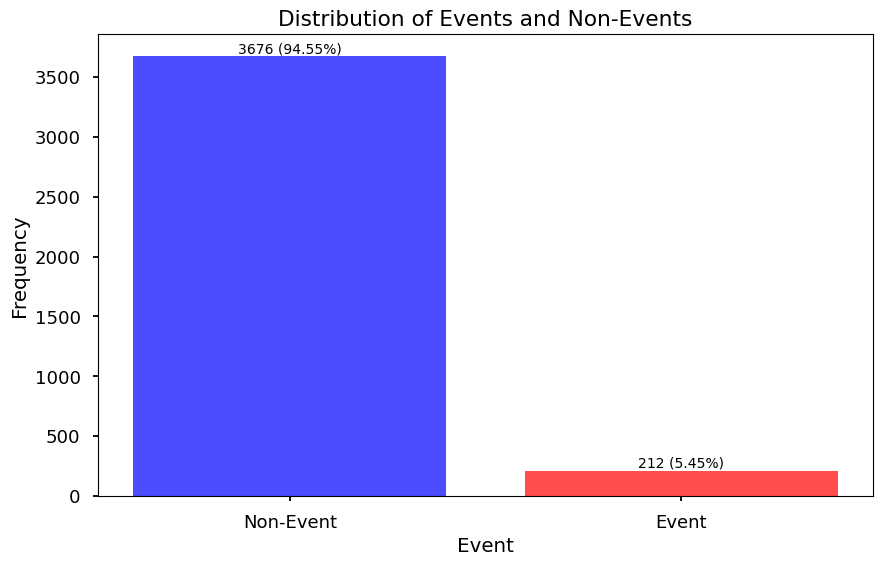

In [184]:
# create distribution of events and non-events
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(combined_df['event'].value_counts().index, combined_df['event'].value_counts().values, color=['blue', 'red'], alpha=0.7)
# add percentage of events and non-events
for i, count in enumerate(combined_df['event'].value_counts().values):
    ax.text(i, count, f"{count} ({count/combined_df.shape[0]*100:.2f}%)", ha='center', va='bottom')
ax.set_title("Distribution of Events and Non-Events")
ax.set_xlabel("Event")
ax.set_ylabel("Frequency")
ax.set_xticklabels(["Non-Event", "Event"])

# Modeling

## Train/Test/Validation Split

In [185]:
data_X = combined_df.dropna(how='any')[['t', 'vo', 'wind_speed','vpd', 'u','v','q','northerliness']]
data_y = combined_df.dropna(how='any')['event'].replace({'non-event': 0, 'event': 1})    

# Train-validation split
from sklearn.model_selection import ShuffleSplit, train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_X, data_y, test_size=0.1, random_state=42) # same as next(ShuffleSplit().split(X, y))

In [186]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5
# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.9]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))

In [187]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # ax.scatter(
    #     range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    # )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

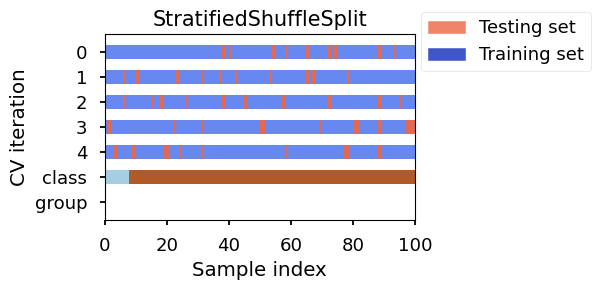

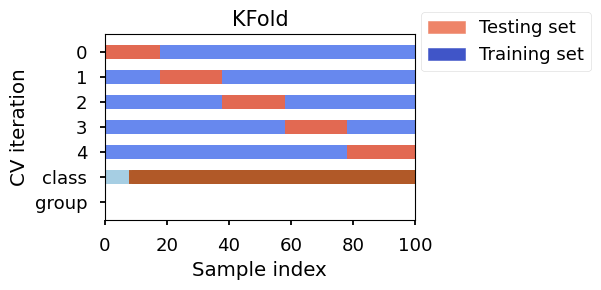

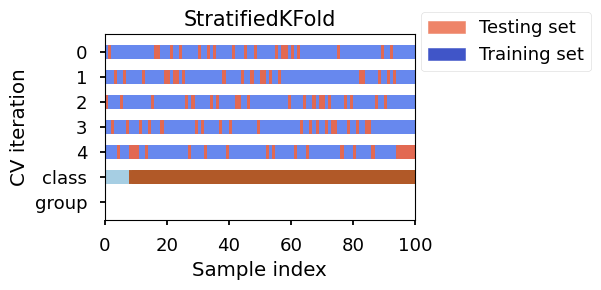

In [188]:
cvs = [StratifiedShuffleSplit, KFold, StratifiedKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    
    if cv == StratifiedKFold:
        plot_cv_indices(cv(n_splits, shuffle=True, random_state=42), X, y, groups, ax, n_splits)
    else:
        plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

In [189]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_predict, cross_validate, ValidationCurveDisplay, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### Training and Cross-Validation

In [190]:
# create cross-validation object consisting of 10 folds using stratified sampling and shufffle given that this is a binary classification problem.
# a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set
# I am shuffling only once to make sure that time series of events does not influence the model result.
cv = StratifiedKFold(n_splits=10, 
                     shuffle=True,
                     random_state=42
                     )
scoring = {"F1":"f1", "Average_Precision":metrics.make_scorer(metrics.average_precision_score)}

## Logistic Regression (Single variable)

In [191]:
data_X_single = combined_df.dropna(how='any')[['wind_speed']]

# Train-validation split
from sklearn.model_selection import ShuffleSplit, train_test_split
X_train_single, X_val_single, y_train_single, y_val_single = train_test_split(data_X_single, data_y, test_size=0.1, random_state=42) # same as next(ShuffleSplit().split(X, y))

In [192]:
lr_single = LogisticRegression(class_weight='balanced', random_state=42, solver='lbfgs', penalty='l2', C=0.5)

In [193]:
# GridSearchCV parameters to test
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = np.arange(0.01, 0.5, 0.01)

# define the grid
param_grid = {
    # 'solver': solvers,
    # 'penalty': penalty,
    'C': c_values,
}

In [194]:
# create the gridsearch
grid_search = GridSearchCV(
    estimator=lr_single, # our logistic regression model
    param_grid=param_grid, # the grid of parameters to test
    scoring=scoring, # the scoring metrics to use
    refit = 'F1', # the metric to use to select the best model
    cv=cv, # the cross-validation object
    n_jobs=4, # use 4 cores
    return_train_score=True, # return the training score
)

In [195]:
# run the model
results_lr = grid_search.fit(X_train_single, y_train_single)
results_lr_cv = results_lr.cv_results_

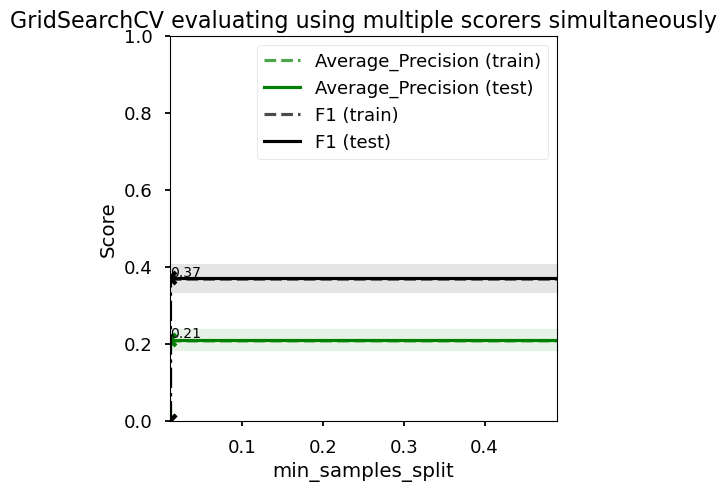

In [196]:
plt.figure(figsize=(5, 5))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(results_lr_cv[f"param_{list(param_grid.keys())[0]}"]), max(results_lr_cv[f"param_{list(param_grid.keys())[0]}"]))
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results_lr_cv[f"param_{list(param_grid.keys())[0]}"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results_lr_cv["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results_lr_cv["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results_lr_cv["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results_lr_cv["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
    # Annotate the best parameter for that scorer
    ax.annotate(
        "%s" % round(X_axis[best_index],1),
        (X_axis[best_index], -0.01),
        ha="center",
        va="top",
    )

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [197]:
print("Best: %f using %s" % (results_lr.best_score_, results_lr.best_params_))
means = results_lr_cv['mean_test_F1']
stds = results_lr_cv['std_test_F1']
params = results_lr_cv['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.371113 using {'C': 0.01}
0.371113 (0.035615) with: {'C': 0.01}
0.371113 (0.035615) with: {'C': 0.02}
0.371113 (0.035615) with: {'C': 0.03}
0.371113 (0.035615) with: {'C': 0.04}
0.371113 (0.035615) with: {'C': 0.05}
0.371113 (0.035615) with: {'C': 0.060000000000000005}
0.371113 (0.035615) with: {'C': 0.06999999999999999}
0.371113 (0.035615) with: {'C': 0.08}
0.371113 (0.035615) with: {'C': 0.09}
0.371113 (0.035615) with: {'C': 0.09999999999999999}
0.371113 (0.035615) with: {'C': 0.11}
0.371113 (0.035615) with: {'C': 0.12}
0.371113 (0.035615) with: {'C': 0.13}
0.371113 (0.035615) with: {'C': 0.14}
0.371113 (0.035615) with: {'C': 0.15000000000000002}
0.371113 (0.035615) with: {'C': 0.16}
0.371113 (0.035615) with: {'C': 0.17}
0.371113 (0.035615) with: {'C': 0.18000000000000002}
0.371113 (0.035615) with: {'C': 0.19}
0.371113 (0.035615) with: {'C': 0.2}
0.371113 (0.035615) with: {'C': 0.21000000000000002}
0.371113 (0.035615) with: {'C': 0.22}
0.371113 (0.035615) with: {'C': 0.23}
0.3

### Fit the best model and classify results

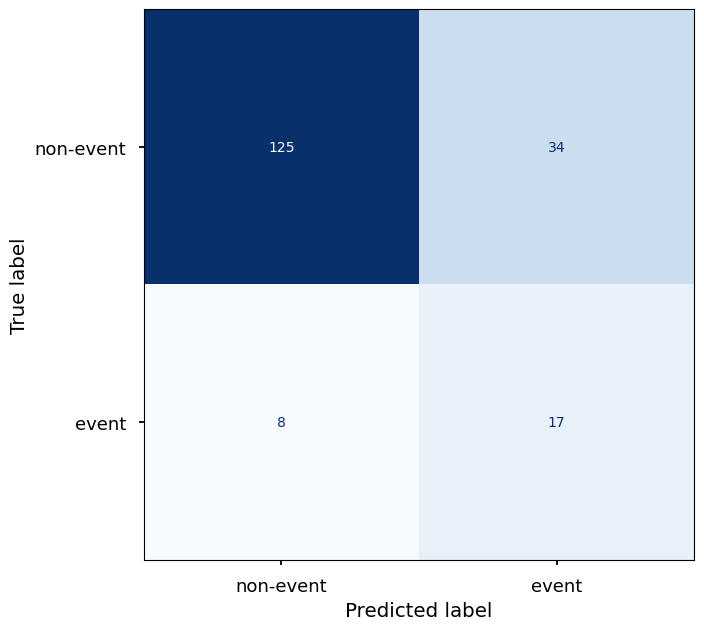

In [198]:
# Fit the model
lr_single_best = LogisticRegression(class_weight='balanced', 
                             random_state=42, 
                             solver='lbfgs', 
                             penalty='l2', 
                             C=0.03).fit(X_train_single, y_train_single)
lr_single_y_pred_proba = lr_single_best.predict_proba(X_val_single)[:, 1]

# ROC
lr_single_fpr, lr_single_tpr, _ = metrics.roc_curve(y_val_single, lr_single_y_pred_proba)
lr_single_roc_auc = metrics.auc(lr_single_fpr, lr_single_tpr)

# PR
lr_single_precision, lr_single_recall, _ = metrics.precision_recall_curve(y_val_single, lr_single_y_pred_proba)
lr_single_average_precision = metrics.average_precision_score(y_val_single, lr_single_y_pred_proba)
lr_single_baseline_precision = y_val_single.sum() / len(y_val_single)

# show confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(lr_single_best, X_val_single, y_val_single, cmap='Blues', colorbar=False, display_labels=['non-event', 'event'])

## Logistic Regressor

Some background. Logistic "regression" is a classification algorithm that is used to predict the *probability* of a categorical dependent value. It sounds similar to linear regression in some ways, but it is distinctly different because the dependent and independent variables are not related linearly, instead the linear relationship is between the independent variables and the logit (log of odds) of independent variable, essentially its probability. The method can then be used to predict the probability of occurrence of a binary event utilizing a logit function (like Sigmoid/logistic function)
$$p = \frac{1}{1+e^{-y}}$$

where $y = \Beta_0 +\Beta_1X_1 +\Beta_2X_2 ...+\Beta_nX_n$

Logistic regression uses maximum liklihood estimation approach. MLE is a liklihood maximation method while OLS is a distance-minimizing method. Maximizing the liklihood function determines parameters that are most likely to produce the observed data

Model choices include:
- not standardized (insensitive to magnitude)
- 80/20 train test split for validation
- cross validation on k=10 folds with stratified shuffle split.
- performance is evaluated using f1-score, 

In [199]:
lr = LogisticRegression(class_weight='balanced', random_state=42, solver='lbfgs', penalty='l2', C=0.5)

In [200]:
# GridSearchCV parameters to test
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = np.arange(0.01, 0.5, 0.01)

# define the grid
param_grid = {
    # 'solver': solvers,
    # 'penalty': penalty,
    'C': c_values,
}

In [201]:
# create the gridsearch
grid_search = GridSearchCV(
    estimator=lr, # our logistic regression model
    param_grid=param_grid, # the grid of parameters to test
    scoring=scoring, # the scoring metrics to use
    refit = 'F1', # the metric to use to select the best model
    cv=cv, # the cross-validation object
    n_jobs=4, # use 4 cores
    return_train_score=True, # return the training score
)

In [202]:
# run the model
results_lr = grid_search.fit(X_train, y_train)
results_lr_cv = results_lr.cv_results_

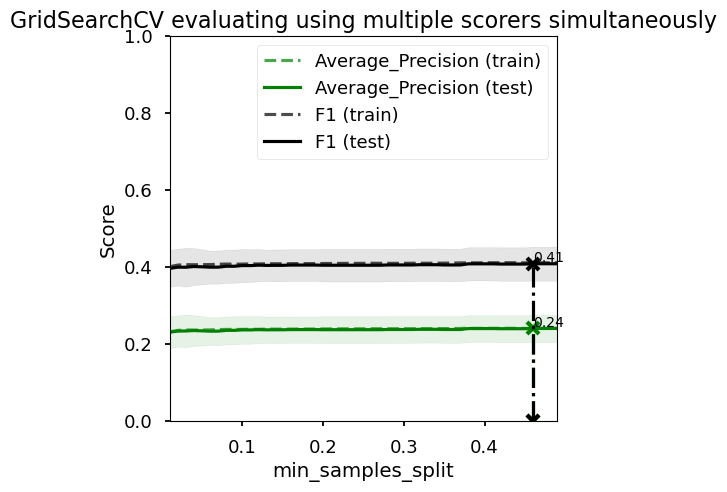

In [203]:
plt.figure(figsize=(5, 5))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(results_lr_cv[f"param_{list(param_grid.keys())[0]}"]), max(results_lr_cv[f"param_{list(param_grid.keys())[0]}"]))
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results_lr_cv[f"param_{list(param_grid.keys())[0]}"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results_lr_cv["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results_lr_cv["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results_lr_cv["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results_lr_cv["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
    # Annotate the best parameter for that scorer
    ax.annotate(
        "%s" % round(X_axis[best_index],1),
        (X_axis[best_index], -0.01),
        ha="center",
        va="top",
    )

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [204]:
print("Best: %f using %s" % (results_lr.best_score_, results_lr.best_params_))
means = results_lr_cv['mean_test_F1']
stds = results_lr_cv['std_test_F1']
params = results_lr_cv['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.408309 using {'C': 0.46}
0.396247 (0.047907) with: {'C': 0.01}
0.399425 (0.047824) with: {'C': 0.02}
0.399242 (0.050367) with: {'C': 0.03}
0.401123 (0.047794) with: {'C': 0.04}
0.400315 (0.045446) with: {'C': 0.05}
0.399411 (0.042770) with: {'C': 0.060000000000000005}
0.399411 (0.042770) with: {'C': 0.06999999999999999}
0.401808 (0.043067) with: {'C': 0.08}
0.401808 (0.043067) with: {'C': 0.09}
0.403600 (0.042945) with: {'C': 0.09999999999999999}
0.403496 (0.042415) with: {'C': 0.11}
0.404632 (0.041749) with: {'C': 0.12}
0.403967 (0.040598) with: {'C': 0.13}
0.404174 (0.041273) with: {'C': 0.14}
0.404174 (0.041273) with: {'C': 0.15000000000000002}
0.404888 (0.041132) with: {'C': 0.16}
0.404888 (0.041132) with: {'C': 0.17}
0.404888 (0.041132) with: {'C': 0.18000000000000002}
0.404888 (0.041132) with: {'C': 0.19}
0.404419 (0.042073) with: {'C': 0.2}
0.404419 (0.042073) with: {'C': 0.21000000000000002}
0.404419 (0.042073) with: {'C': 0.22}
0.404419 (0.042073) with: {'C': 0.23}
0.4

### Fit the best model and classify results

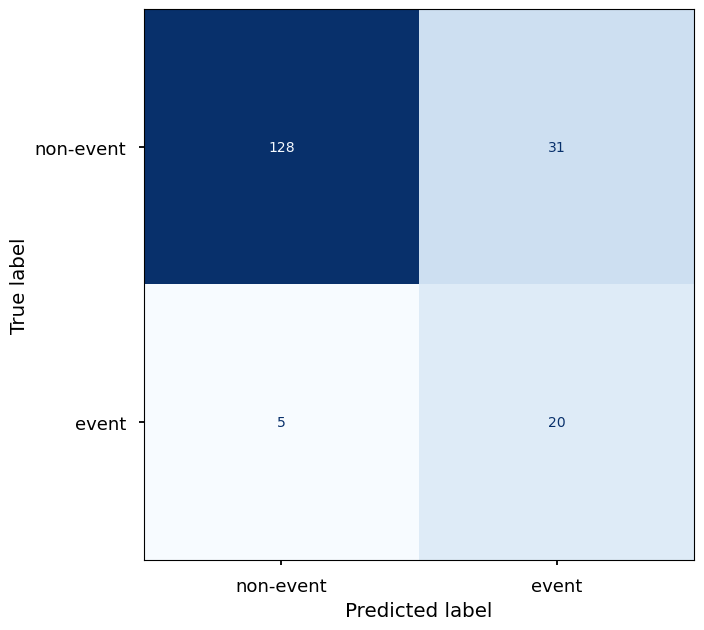

In [205]:
# Fit the model
lr_best = LogisticRegression(class_weight='balanced', 
                             random_state=42, 
                             solver='lbfgs', 
                             penalty='l2', 
                             C=0.03).fit(X_train, y_train)
lr_y_pred_proba = lr_best.predict_proba(X_val)[:, 1]

# ROC
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_val, lr_y_pred_proba)
lr_roc_auc = metrics.auc(lr_fpr, lr_tpr)

# PR
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_val, lr_y_pred_proba)
lr_average_precision = metrics.average_precision_score(y_val, lr_y_pred_proba)
lr_baseline_precision = y_val.sum() / len(y_val)

# show confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(lr_best, X_val, y_val, cmap='Blues', colorbar=False, display_labels=['non-event', 'event'])

## Random Forest Classifier

### ML Packages 

In [206]:
# machine learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier 

In [278]:
rf = RandomForestClassifier(random_state=42, 
                            max_depth=15, 
                            max_features=4,
                            n_estimators=5, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            )
# Best results with areal average was 0.5 for max_depth=7, max_features=3,n_estimators=20, min_samples_split=10 hyperparameters
# Best results with closest point was 0.52 for max_depth=10, max_features=4,n_estimators=60, min_samples_split=5, min_samples_leaf=4 hyperparameters
# Best result for 5-grid areal average was 0.545171 (0.109243) with: {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
# Best result for 17x17 grid was 0.589166  using {'max_depth': 15, 'max_features': 4, 'min_samples_split': 2, n_estimators': 5, 'min_samples_leaf': 2}
# define the grid
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50,100], # number of trees in the forest
    'max_depth': [5,7,10,15], # maximum depth of the tree, balances overfitting and underfitting
    # 'min_samples_split': [2, 5, 10,15,20], # minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 2, 4, 5, 10, 15, 20], # minimum number of samples required to be at a leaf node
    'max_features': [2,3,4,5], # number of features to consider when looking for the best split
}

# scoring metrics
scoring = {"F1":"f1", 
           "Average_Precision":metrics.make_scorer(metrics.average_precision_score),
        #    "Recall":metrics.make_scorer(metrics.recall_score),
        #    "Precision":metrics.make_scorer(metrics.precision_score),
           }

In [279]:
rf_grid_search = GridSearchCV(
    estimator=rf, # our logistic regression model
    param_grid=param_grid, # the grid of parameters to test
    scoring=scoring, # the scoring metrics to use
    refit = 'Average_Precision', # the metric to use to select the best model
    cv=cv, # the cross-validation object
    n_jobs=4, # use 4 cores
    return_train_score=True, # return the training score
)
results_rf = rf_grid_search.fit(X_train, y_train)
results_rf_cv = results_rf.cv_results_

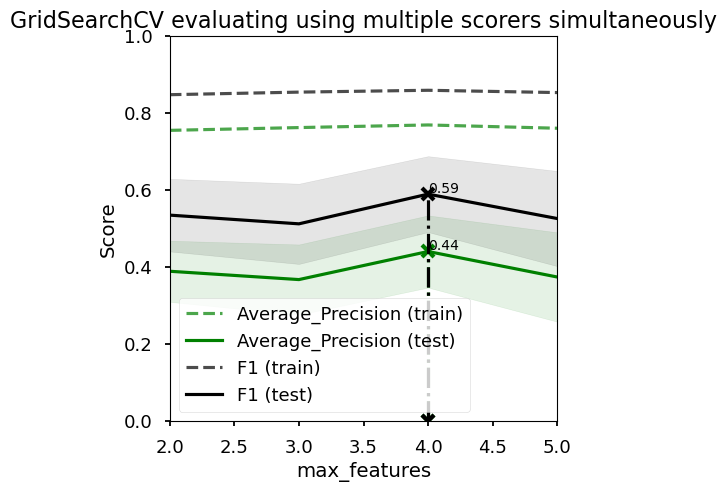

In [ ]:
plt.figure(figsize=(5, 5))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel(list(param_grid.keys())[0])
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(results_rf_cv[f"param_{list(param_grid.keys())[0]}"]), max(results_rf_cv[f"param_{list(param_grid.keys())[0]}"]))
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results_rf_cv[f"param_{list(param_grid.keys())[0]}"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k", ]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results_rf_cv["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results_rf_cv["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results_rf_cv["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results_rf_cv["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
    # Annotate the best parameter for that scorer
    ax.annotate(
        "%s" % round(X_axis[best_index],1),
        (X_axis[best_index], -0.01),
        ha="center",
        va="top",
    )

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [280]:
print("Best: %f using %s" % (results_rf.best_score_, results_rf.best_params_))
means = results_rf_cv['mean_test_F1']
stds = results_rf_cv['std_test_F1']
params = results_rf_cv['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.440163 using {'max_depth': 15, 'max_features': 4, 'n_estimators': 5}
0.478830 (0.086102) with: {'max_depth': 5, 'max_features': 2, 'n_estimators': 5}
0.482948 (0.095830) with: {'max_depth': 5, 'max_features': 2, 'n_estimators': 10}
0.473944 (0.090919) with: {'max_depth': 5, 'max_features': 2, 'n_estimators': 20}
0.470790 (0.092842) with: {'max_depth': 5, 'max_features': 2, 'n_estimators': 30}
0.480525 (0.092493) with: {'max_depth': 5, 'max_features': 2, 'n_estimators': 40}
0.479924 (0.103490) with: {'max_depth': 5, 'max_features': 2, 'n_estimators': 50}
0.463628 (0.108054) with: {'max_depth': 5, 'max_features': 2, 'n_estimators': 100}
0.475865 (0.106233) with: {'max_depth': 5, 'max_features': 3, 'n_estimators': 5}
0.491059 (0.099070) with: {'max_depth': 5, 'max_features': 3, 'n_estimators': 10}
0.505324 (0.109873) with: {'max_depth': 5, 'max_features': 3, 'n_estimators': 20}
0.499324 (0.108351) with: {'max_depth': 5, 'max_features': 3, 'n_estimators': 30}
0.499324 (0.108351) wi

Text(0.5, 1.0, 'Feature Importance')

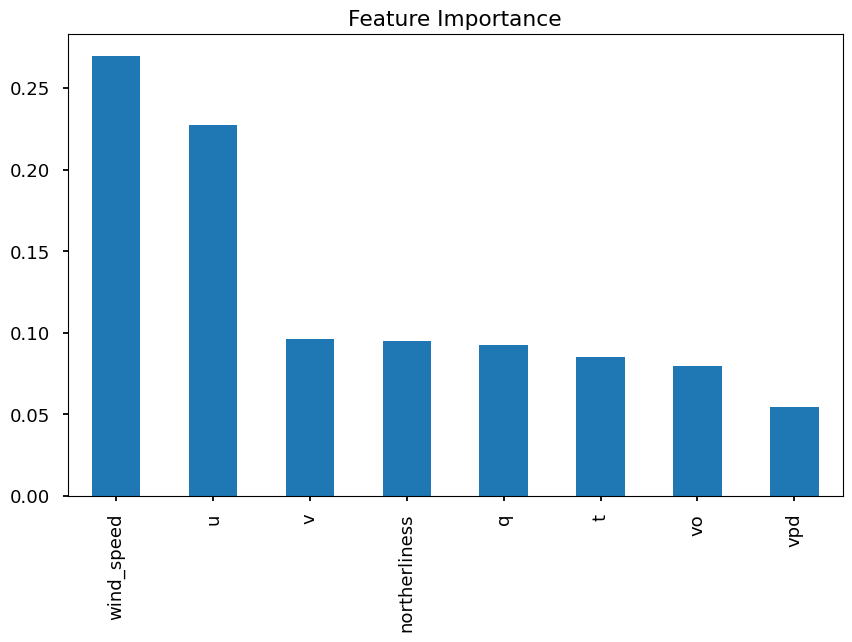

In [222]:
important_features = pd.Series(data=results_rf.best_estimator_.feature_importances_,index=data_X.columns)
important_features.sort_values(ascending=False,inplace=True)

# plot
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar')
plt.title('Feature Importance')

### Fit the best model and classify results

F1 Score:  0.5789473684210525
AP: 0.4483946488294314


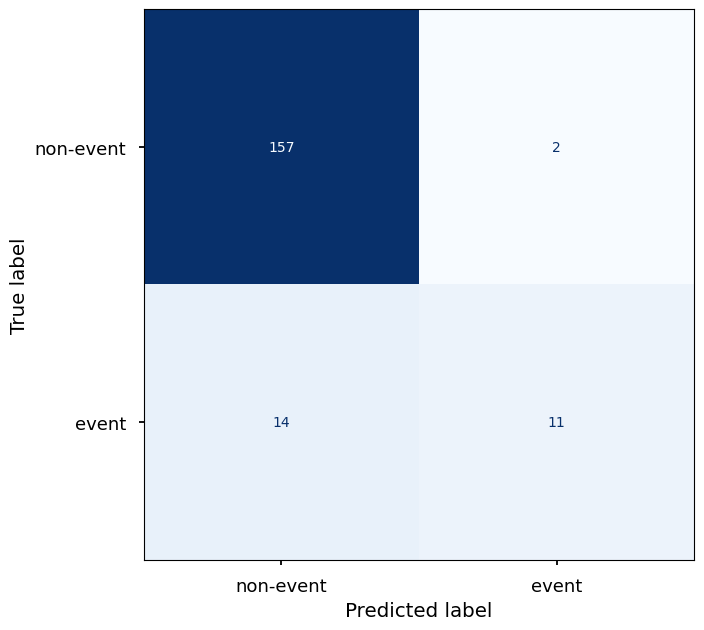

In [223]:
# Fit the model
rf_best_0point2 = RandomForestClassifier(random_state=42, 
                            max_depth=10, 
                            max_features=5,
                            n_estimators=30, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            ).fit(X_train, y_train)
rf_best_0point3 = RandomForestClassifier(random_state=42, 
                            max_depth=9, 
                            max_features=4,
                            n_estimators=30, 
                            min_samples_split=2,
                            min_samples_leaf=1
                            ).fit(X_train, y_train)
rf_best_0point4 = RandomForestClassifier(random_state=42, 
                            max_depth=15, 
                            max_features=4,
                            n_estimators=30, 
                            min_samples_split=5,
                            min_samples_leaf=2,
                            ).fit(X_train, y_train)
rf_best = RandomForestClassifier(random_state=42, 
                            max_depth=15, 
                            max_features=4,
                            n_estimators=5, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            ).fit(X_train, y_train)
                                 
rf_y_pred_proba = rf_best.predict_proba(X_val)[:, 1]

# ROC
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_val, rf_y_pred_proba)
rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)

# PR
rf_precision, rf_recall, _ = metrics.precision_recall_curve(y_val, rf_y_pred_proba)
rf_average_precision = metrics.average_precision_score(y_val, rf_y_pred_proba)
rf_baseline_precision = y_val.sum() / len(y_val)

# Show confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(rf_best, X_val, y_val, cmap='Blues', colorbar=False, display_labels=['non-event', 'event'])
# print f1 score
print("F1 Score: ", metrics.f1_score(y_val, rf_best.predict(X_val)))
# print average precision score
print(f"AP: {metrics.average_precision_score(y_val, rf_best.predict(X_val))}")

## XGBoost Classifier

In [ ]:
xgb = XGBClassifier(random_state=42, 
                                   n_estimators= 80, 
                                   scale_pos_weight=50, 
                                   learning_rate=0.3,
                                   max_depth=7,
                                   subsample= 0.9,
                                   objective="binary:logistic"
                                )
# best result for areal average was 0.64 for n_estimators= 30, scale_pos_weight= 10, learning_rate=0.3, max_depth=7, subsample= 0.3
# best result for closest point was 0.57 Best: 0.571022 using {'learning_rate': 0.7, 'max_depth': 7, 'scale_pos_weight': 5, 'subsample': 0.7}
# best result for 5-grid average was 0.59 {'learning_rate': 0.2, 'max_depth': 10, 'scale_pos_weight': 8, 'subsample': 0.5, n_estimators:30}
# best result for 10-grid average was 0.61 {'learning_rate': 0.1, 'max_depth': 10, 'scale_pos_weight': 5, 'subsample': 0.7, 'n_estimators': 60}
# best result for 20-grid average was 0.66 using {'learning_rate': 0.2, 'max_depth': 7, 'scale_pos_weight': 10, 'subsample': 0.5}!!
# best result for 17x17 grid was 0.63 {'learning_rate': 0.5, 'max_depth': 7, 'subsample': 0.9, n_estimators': 80, 'scale_pos_weight': 50}
default = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the range of scale_pos_weight ratios to test
ratios = [5, 10, 20, 50, 100]
# define the grid
param_grid = {
    # 'learning_rate':  [0.1, 0.2, 0.3,0.5,0.7], # st controls the step size at each boosting iteration
    'n_estimators': np.arange(10,100,10), # number of trees in the forest
    # 'max_depth': [2,3,5,7,10], # controls the maximum depth of the decision trees used in the model
    # 'scale_pos_weight': ratios, # controls the balance of positive and negative weights
    # 'subsample': [0.1,0.3, 0.5, 0.7, 0.9, 1.], # fraction of samples to be used for each tree
}

# scoring metrics
scoring = {"F1":"f1", 
           "Average_Precision":metrics.make_scorer(metrics.average_precision_score),
        #    "Recall":metrics.make_scorer(metrics.recall_score),
        #    "Precision":metrics.make_scorer(metrics.precision_score),
           }
xgb_grid_search = GridSearchCV(
    estimator=xgb, # our logistic regression model
    param_grid=param_grid, # the grid of parameters to test
    scoring=scoring, # the scoring metrics to use
    refit = 'Average_Precision', # the metric to use to select the best model
    cv=cv, # the cross-validation object
    n_jobs=4, # use 4 cores
    return_train_score=True, # return the training score
)
results_xgb = xgb_grid_search.fit(X_train, y_train)
results_xgb_cv = results_xgb.cv_results_

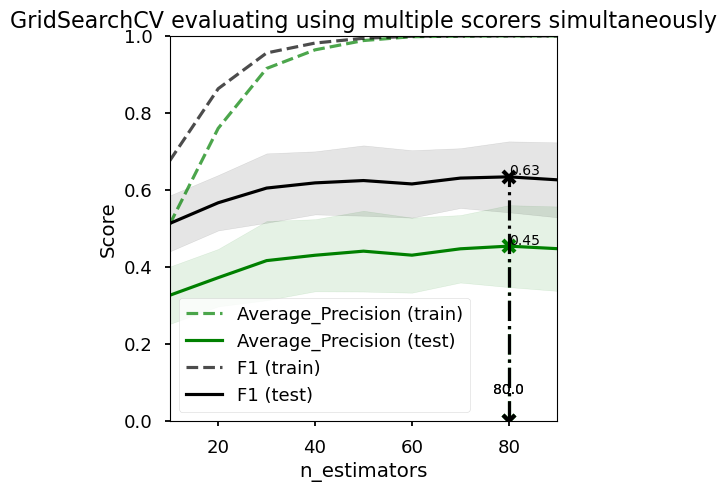

In [290]:
plt.figure(figsize=(5, 5))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel(list(param_grid.keys())[0])
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(results_xgb_cv[f"param_{list(param_grid.keys())[0]}"]), max(results_xgb_cv[f"param_{list(param_grid.keys())[0]}"]))
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results_xgb_cv[f"param_{list(param_grid.keys())[0]}"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k", ]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results_xgb_cv["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results_xgb_cv["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results_xgb_cv["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results_xgb_cv["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
    # Annotate the best parameter for that scorer
    ax.annotate(
        "%s" % round(X_axis[best_index],1),
        (X_axis[best_index], 0.1),
        ha="center",
        va="top",
    )

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [291]:
print("Best: %f using %s" % (results_xgb.best_score_, results_xgb.best_params_))
means = results_xgb_cv['mean_test_F1']
stds = results_xgb_cv['std_test_F1']
params = results_xgb_cv['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.454093 using {'n_estimators': 80}
0.512968 (0.072644) with: {'n_estimators': 10}
0.566693 (0.071973) with: {'n_estimators': 20}
0.604863 (0.090088) with: {'n_estimators': 30}
0.618348 (0.081933) with: {'n_estimators': 40}
0.624406 (0.091357) with: {'n_estimators': 50}
0.615591 (0.087617) with: {'n_estimators': 60}
0.630777 (0.077662) with: {'n_estimators': 70}
0.634072 (0.092131) with: {'n_estimators': 80}
0.626292 (0.097308) with: {'n_estimators': 90}


Text(0.5, 1.0, 'Feature Importance')

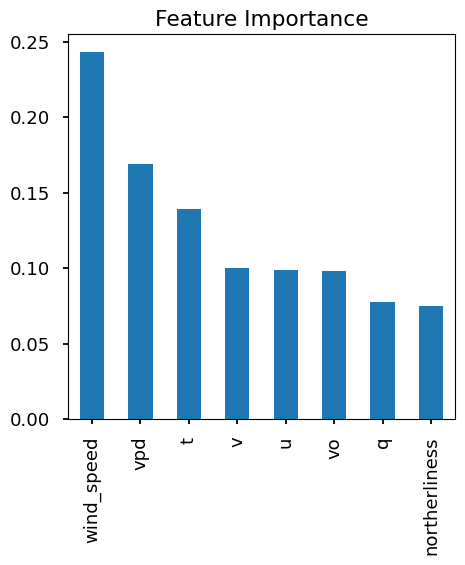

In [292]:
important_features = pd.Series(data=results_xgb.best_estimator_.feature_importances_,index=data_X.columns)
important_features.sort_values(ascending=False,inplace=True)

# plot
plt.figure(figsize=(5, 5))
important_features.plot(kind='bar')
plt.title('Feature Importance')

### Fit the best model and classify results

In [293]:
# Fit the model 
#   n_estimators= 40, scale_pos_weight=20, learning_rate=0.2,max_depth=7,subsample= 0.5,
xgb_best_0point2 = XGBClassifier(random_state=42, 
                                 n_estimators= 40, 
                                   scale_pos_weight=10, 
                                   learning_rate=0.3,
                                   max_depth=10,
                                   subsample= 0.9,
                                   objective="binary:logistic"
                                ).fit(X_train, y_train)

xgb_best_0point3 = XGBClassifier(random_state=42, 
                                 n_estimators= 40, 
                                 scale_pos_weight=20, 
                                 learning_rate=0.2,
                                 max_depth=7,
                                 subsample= 0.5,
                                  objective="binary:logistic"
                                ).fit(X_train, y_train)
xgb_best_0point4 = XGBClassifier(random_state=42, 
                                   n_estimators= 40, 
                                   scale_pos_weight=8, 
                                   learning_rate=0.5,
                                   max_depth=7,
                                   subsample= 0.9,
                                  objective="binary:logistic"
                                ).fit(X_train, y_train)
xgb_best = XGBClassifier(random_state=42, 
                                   n_estimators= 80, 
                                   scale_pos_weight=50, 
                                   learning_rate=0.3,
                                   max_depth=7,
                                   subsample= 0.9,
                                   objective="binary:logistic"
                                ).fit(X_train, y_train)
y_pred_proba = xgb_best.predict_proba(X_val)[:, 1]

# ROC
xgb_fpr, xgb_tpr, _ = metrics.roc_curve(y_val, y_pred_proba)
xgb_roc_auc = metrics.auc(xgb_fpr, xgb_tpr)

# PR
xgb_precision, xgb_recall, _ = metrics.precision_recall_curve(y_val, y_pred_proba)
xgb_average_precision = metrics.average_precision_score(y_val, y_pred_proba)
xgb_baseline_precision = y_val.sum() / len(y_val)

# Compare Model Performance

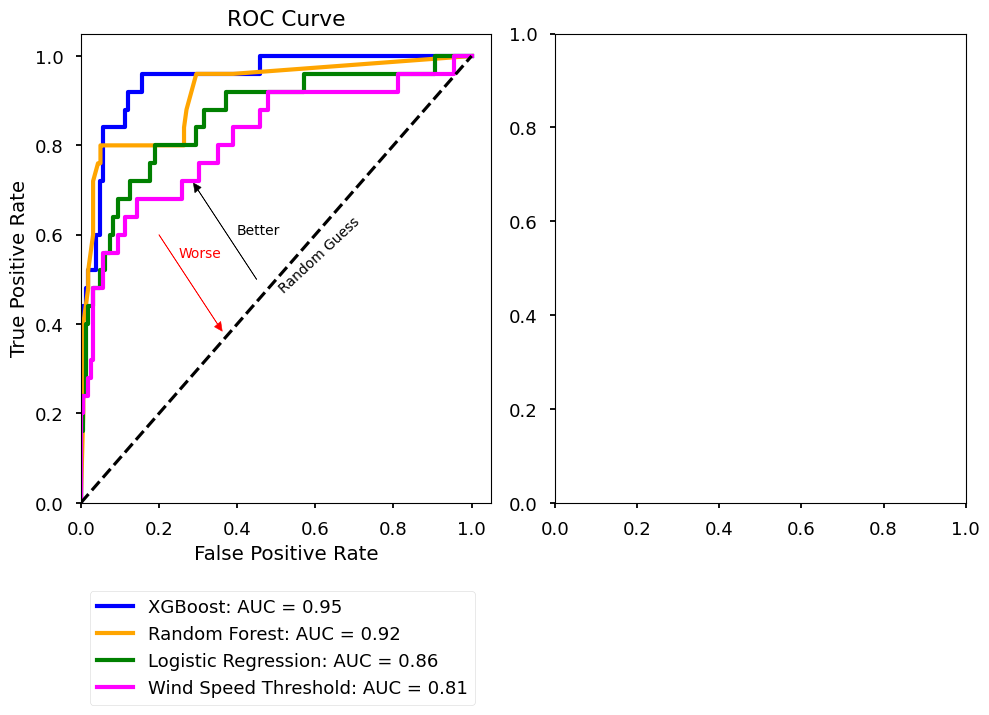

In [294]:
# Plot side-by-side
plt.style.use('seaborn-v0_8-talk')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7), tight_layout=True)

# ROC Plot
ax1.plot(xgb_fpr, xgb_tpr, lw=3, label=f'XGBoost: AUC = {xgb_roc_auc:.2f}', color='blue', )
ax1.plot(rf_fpr, rf_tpr, lw=3, label=f'Random Forest: AUC = {rf_roc_auc:.2f}', color='orange')
ax1.plot(lr_fpr, lr_tpr, lw=3, label=f'Logistic Regression: AUC = {lr_roc_auc:.2f}', color='green')
ax1.plot(lr_single_fpr, lr_single_tpr, lw=3, label=f'Wind Speed Threshold: AUC = {lr_single_roc_auc:.2f}', color='magenta')
ax1.plot([0, 1], [0, 1], 'k--')

# Inline labels
# ax1.annotate(f'AUC = {xgb_roc_auc:.2f}', xy=(0.1, 0.9), xycoords='data', fontsize=12, color='blue', rotation=10)
ax1.text(0.5, 0.47, 'Random Guess', color='black', fontsize=10, rotation=43)

# Axes and annotations
ax1.set_xlim([0.0, 1.05])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

ax1.text(0.4, 0.6, 'Better', fontsize=10, color='black')
ax1.text(0.25, 0.55, 'Worse', fontsize=10, color='red')
ax1.arrow(0.2, 0.6, 0.15, -0.2, head_width=0.02, head_length=0.02, fc='red', ec='red')
ax1.arrow(0.45, 0.5, -0.15, 0.2, head_width=0.02, head_length=0.02, fc='black', ec='black')

ax1.legend(loc='lower left', bbox_to_anchor=(0, -0.45))

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of the fraction of relevant items among actually returned items while recall is a measure of the fraction of items that were returned among all items that should have been returned. ‘Relevancy’ here refers to items that are postively labeled, i.e., true positives and false negatives.

Precision is defined as the number of true positives over the number of true positives plus the number of false positives.

Recall is defined as the number of true posistives over the number of true positives plus the number of false negatives.

The PR-curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision. High precision is achieved by having few false positives in the returned results, and high recall is obtained by having few false negatives in the relevant results. High scores show that the classifier is returning accurate results and a majority of relevant results. 

A system with high recall but low precision returns most of the relevant items but the proportion of returned results that are incorrectly labeled is high.

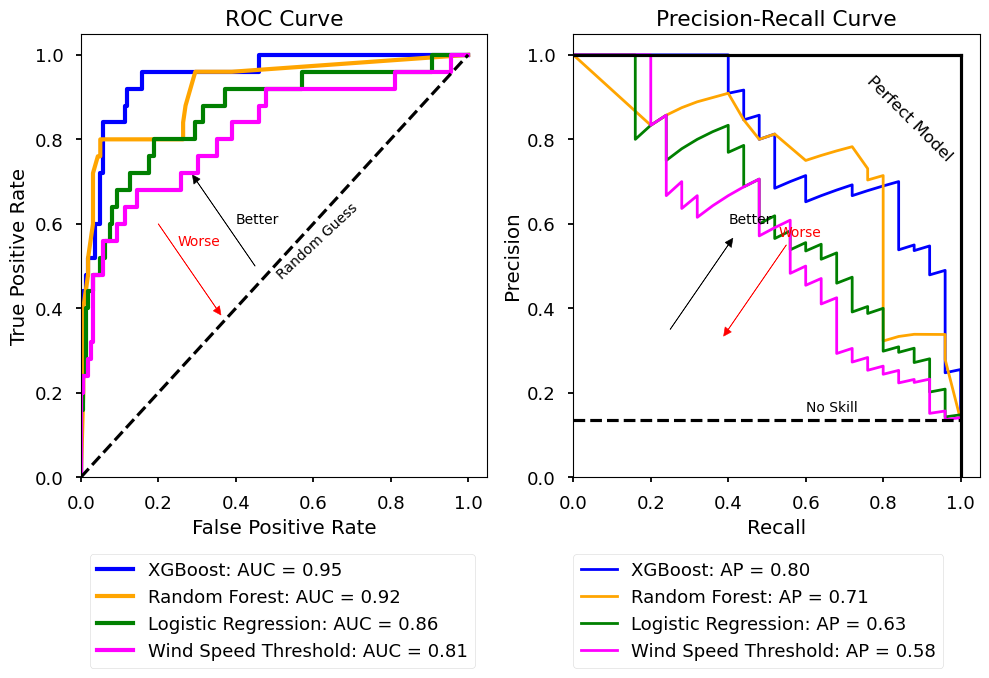

In [295]:
# PR Plot
ax2.plot(xgb_recall, xgb_precision, lw=2,label=f'XGBoost: AP = {xgb_average_precision:.2f}', color='blue')
ax2.plot(rf_recall, rf_precision, lw=2,label=f'Random Forest: AP = {rf_average_precision:.2f}', color='orange')
ax2.plot(lr_recall, lr_precision, lw=2,label=f'Logistic Regression: AP = {lr_average_precision:.2f}', color='green')
ax2.plot(lr_single_recall, lr_single_precision,lw=2, label=f'Wind Speed Threshold: AP = {lr_single_average_precision:.2f}', color='magenta')
ax2.plot([0, 1], [xgb_baseline_precision, xgb_baseline_precision], 'k--')
ax2.plot([0, 1], [1,1], 'k')
ax2.plot([1, 1], [0,1], 'k')

# Inline labels
# ax2.annotate(f'AP = {xgb_average_precision:.2f}', xy=(0.55, 0.7), xycoords='data', fontsize=12, color='blue', rotation=-35)
ax2.text(0.6, xgb_baseline_precision + 0.02, 'No Skill', color='black', fontsize=10)
ax2.annotate("Perfect Model", xy=(0.75, 0.75), xycoords='data', fontsize=12, color='black', rotation=-45)

ax2.text(0.4, 0.6, 'Better', fontsize=10, color='black')
ax2.text(0.53, 0.57, 'Worse', fontsize=10, color='red')
ax2.arrow(0.55, 0.55, -0.15, -0.2, head_width=0.02, head_length=0.02, fc='red', ec='red')
ax2.arrow(0.25, 0.35, 0.15, 0.2, head_width=0.02, head_length=0.02, fc='black', ec='black')

# Axes and annotations
ax2.set_xlim([0.0, 1.05])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

ax2.legend(loc='lower left', bbox_to_anchor=(0, -0.43), borderaxespad=0.)
fig

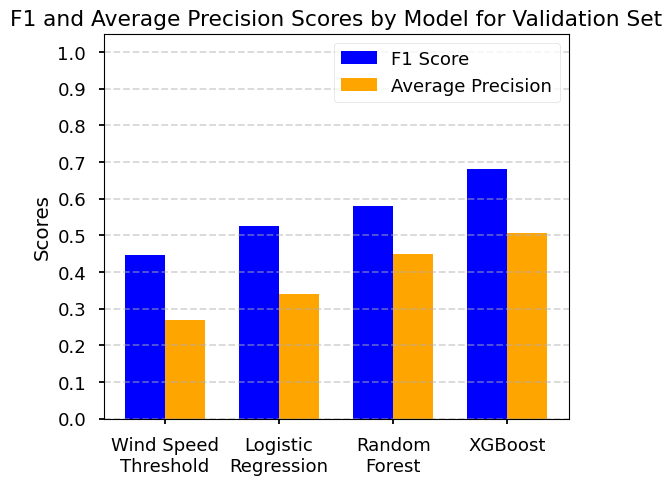

In [296]:
# Validation F1 scores
lr_single_val_f1 = metrics.f1_score(y_val_single, lr_single_best.predict(X_val_single))
lr_val_f1 = metrics.f1_score(y_val, lr_best.predict(X_val))
rf_val_f1 = metrics.f1_score(y_val, rf_best.predict(X_val))
xgb_val_f1 = metrics.f1_score(y_val, xgb_best.predict(X_val))

# Validation AP
lr_single_val_ap = metrics.average_precision_score(y_val_single, lr_single_best.predict(X_val_single))
lr_val_ap = metrics.average_precision_score(y_val, lr_best.predict(X_val))
rf_val_ap = metrics.average_precision_score(y_val, rf_best.predict(X_val))
xgb_val_ap = metrics.average_precision_score(y_val, xgb_best.predict(X_val))

# offset scores under each label
labels = ['Wind Speed\nThreshold', 'Logistic\nRegression', 'Random\nForest', 'XGBoost']
f1_scores = [lr_single_val_f1, lr_val_f1, rf_val_f1, xgb_val_f1]
ap_scores = [lr_single_val_ap, lr_val_ap, rf_val_ap, xgb_val_ap]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# bar plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=10)
rects1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='blue')
rects2 = ax.bar(x + width/2, ap_scores, width, label='Average Precision', color='orange')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('F1 and Average Precision Scores by Model for Validation Set')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha='center', va='top')
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.set_ylim(0,1.05)
ax.legend()


<!-- # Apply to timeseries -->

In [301]:
water_years = np.arange(1980,2025)
result_df = pd.DataFrame(index=water_years, columns=['no_of_events', 'length_of_winter', 'percentage_of_events', 'sublimation_event_hours','average_wind_speed'])
monthly_results = pd.DataFrame(index=water_years, columns=['December', 'January', 'February', 'March'])
for water_year in water_years:
    print(f"Opening {water_year} data...")
    winter_slice = slice(f'{water_year-1}-12-01',f'{water_year}-03-31')
    # open reanalysis data
    tmp_wy1_ds = xr.open_dataset(f'/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_{water_year-1}_v2.nc').sel(latitude=lat_sel, longitude=lon_sel).squeeze()
    tmp_wy2_ds = xr.open_dataset(f'/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_{water_year}_v2.nc').sel(latitude=lat_sel, longitude=lon_sel).squeeze()

    # merge datasets
    tmp_ds = xr.concat([tmp_wy1_ds, tmp_wy2_ds], dim='valid_time')
    # filter for winter months
    tmp_ds = tmp_ds.sel(valid_time=winter_slice)

    # calculate average in space and 3H average in time
    tmp_ds = tmp_ds.mean(dim=['latitude','longitude']).resample(valid_time='3H').mean()

    # calculate wind speed and temperature in degC
    tmp_ds['wind_speed'] = np.sqrt(tmp_ds['u']**2 + tmp_ds['v']**2)
    # create a column with the wind direction
    tmp_ds['wind_dir'] = np.arctan2(tmp_ds['v'], tmp_ds['u']) * 180 / np.pi
    # convert wind direction to compass direction
    tmp_ds['wind_dir'] = (270 - tmp_ds['wind_dir']) % 360

    # calculate "northerliness"
    tmp_ds['northerliness'] = np.cos(np.deg2rad(tmp_ds['wind_dir']))
    
    tmp_ds['t'] = (tmp_ds['t'] - 273.15) * units.units('degC') # convert to Celsius

    # calculate vapor pressure deficit
    tmp_ds['vpd'] = calc.saturation_vapor_pressure((tmp_ds['t'])) - tmp_ds['q'] * units.units('Pa')

    print("Data merged and cleaned...")
    data = tmp_ds.to_dataframe()[['t', 'vo', 'wind_speed','vpd', 'u','v','q','northerliness']].reset_index(drop=True)
    # Step 1: Standardize features
    prediction = xgb_best.predict(data.values)

    # Monthly averages
    monthly_values = pd.DataFrame(index=tmp_ds['valid_time'].values, data=prediction).resample('1M').sum()
    monthly_results.loc[water_year, 'December'] = monthly_values.iloc[0].values[0]*3 / (31*24)
    monthly_results.loc[water_year, 'January'] = monthly_values.iloc[1].values[0]*3 / (31*24)
    monthly_results.loc[water_year, 'February'] = monthly_values.iloc[2].values[0]*3 / (28.25*24)
    monthly_results.loc[water_year, 'March'] = monthly_values.iloc[3].values[0]*3 / (31*24)

    # total number of hours during events
    length_of_winter = len(prediction)
    # number of periods with events
    num_events = np.sum(prediction)
    # Calculate the percentage of time during which events were observed
    percentage_of_events = (num_events / length_of_winter) * 100

    # calculate how many discrete events were present 
    discrete_events = 0
    counter = 0
    # Loop through the predictions to count discrete events
    discrete_events = 0
    counter = 0
    for i,p in enumerate(prediction):
        if p == 1:
            counter += 1
            # if the counter is greater than 1 and we have reached the final value, add to  the discrete events
            if (counter > 3)and (i == len(prediction)-1):
                discrete_events += 1
        elif (p==0) & (counter>3):
            discrete_events += 1
            counter = 0
    result_df.loc[water_year, 'average_wind_speed'] = tmp_ds['wind_speed'].mean().values
    result_df.loc[water_year, 'no_of_events'] = num_events
    result_df.loc[water_year, 'length_of_winter'] = length_of_winter
    result_df.loc[water_year, 'percentage_of_events'] = percentage_of_events
    result_df.loc[water_year, 'sublimation_event_hours'] = discrete_events
            
    print("Data saved...")

Opening 1980 data...
Data merged and cleaned...
Data saved...
Opening 1981 data...
Data merged and cleaned...
Data saved...
Opening 1982 data...
Data merged and cleaned...
Data saved...
Opening 1983 data...
Data merged and cleaned...
Data saved...
Opening 1984 data...
Data merged and cleaned...
Data saved...
Opening 1985 data...
Data merged and cleaned...
Data saved...
Opening 1986 data...
Data merged and cleaned...
Data saved...
Opening 1987 data...
Data merged and cleaned...
Data saved...
Opening 1988 data...
Data merged and cleaned...
Data saved...
Opening 1989 data...
Data merged and cleaned...
Data saved...
Opening 1990 data...
Data merged and cleaned...
Data saved...
Opening 1991 data...
Data merged and cleaned...
Data saved...
Opening 1992 data...
Data merged and cleaned...
Data saved...
Opening 1993 data...
Data merged and cleaned...
Data saved...
Opening 1994 data...
Data merged and cleaned...
Data saved...
Opening 1995 data...
Data merged and cleaned...
Data saved...
Opening 

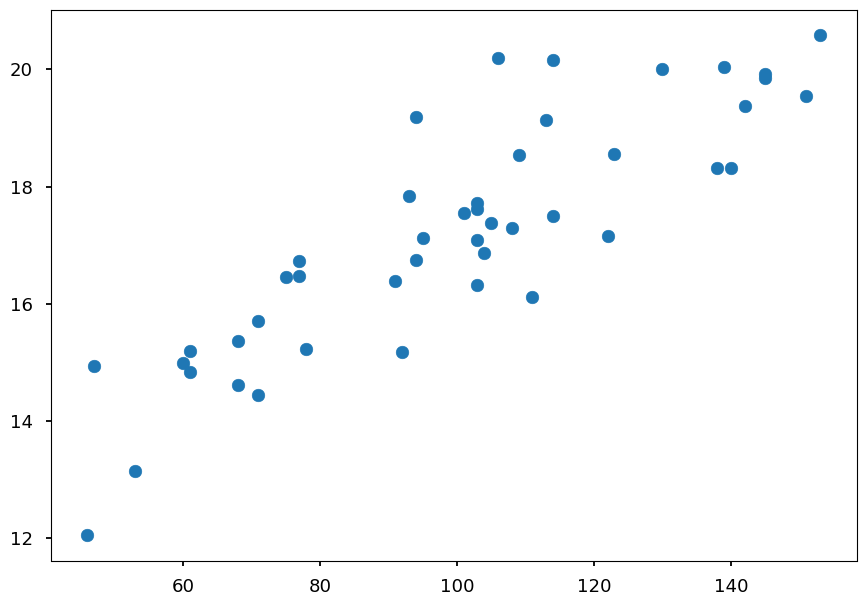

In [306]:
plt.scatter(result_df['no_of_events'], result_df['average_wind_speed'])
# add the r2 between variables
from scipy.stats import linregress
# slope, intercept, r_value, p_value, std_err = linregress(result_df['no_of_events'], result_df['average_wind_speed'])
# plt.plot(result_df['no_of_events'], intercept + slope * result_df['no_of_events'], 'r', label='fitted line')

In [307]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    x=result_df.index,
    y=result_df['no_of_events']*3,
    mode='lines+markers',
    name='Percentage of Events',
    line=dict(color='blue', width=2),   
), secondary_y=False,)
fig.add_trace(go.Scatter(
    x=[2022, 2023],
    y=[len(w22_large_sublimation_long_events)*3, len(w23_large_sublimation_long_events)*3],
    mode='markers',
    name='Observed',
    marker=dict(color='red', size=10)
), secondary_y=False,)  

# add secondary axis with average wind speed
fig.add_trace(go.Scatter(
    x=result_df.index,
    y=result_df['average_wind_speed'],
    mode='lines+markers',
    name='Average Wind Speed',
    line=dict(color='orange', width=2),\
), secondary_y=True,)

fig.update_layout(
    width=1000,
    height=400,
    title='Total Number of Hours with Sublimation Events by Winter',
    xaxis_title='Water Year',
    yaxis_title='Hours',
    yaxis2_title='Average Wind Speed (m/s)',
)

In [308]:
# observations from GUC sounding
guc_obs = pd.read_csv('./01_data/processed_data/winter_500mb_GUC_winds.csv', index_col=0)

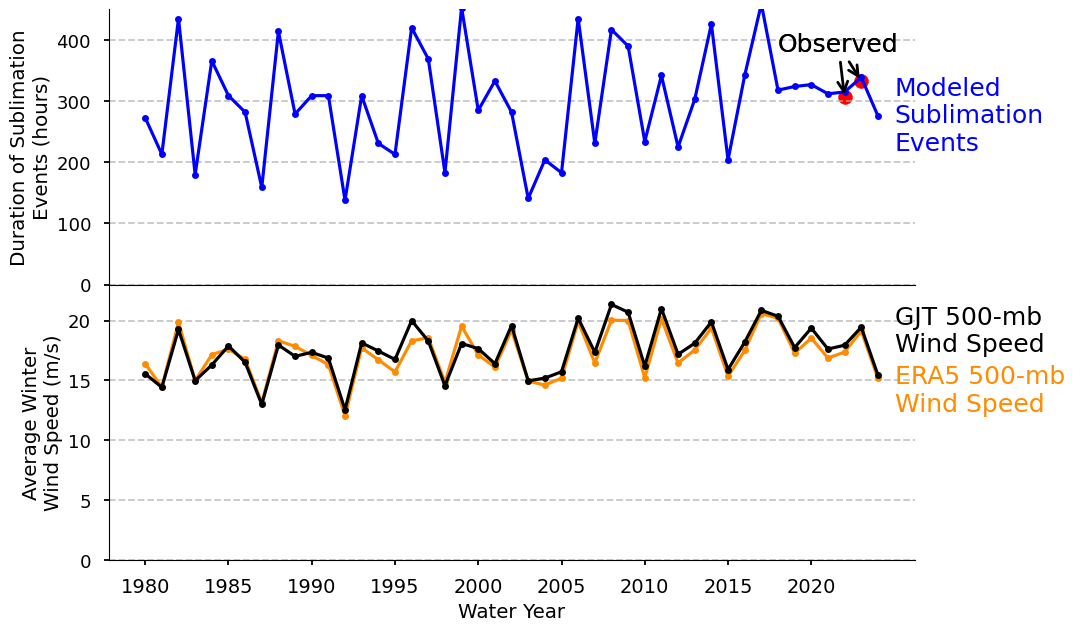

In [309]:
from matplotlib import gridspec
plt.style.use('seaborn-v0_8-talk')


fig = plt.figure()

# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 2]) 

# the first subplot
ax0 = plt.subplot(gs[0])

ax0.plot(result_df.index, result_df['no_of_events']*3, '-o', color='blue', label='Duration of Sublimation Events', markersize=5)
ax0.scatter(x=[2022, 2023],
            y=[len(w22_large_sublimation_long_events)*3, len(w23_large_sublimation_long_events)*3],
            color='red', s=100, label='Observed')
ax0.set_ylabel('Duration of Sublimation\nEvents (hours)')
# add horizontal grid
ax0.grid(axis='y', linestyle='--', alpha=0.7)
ax0.set_ylim(0,450)

# annotate observed values
ax0.annotate('Observed', xy=(2022, len(w22_large_sublimation_long_events)*3), xytext=(2018, len(w22_large_sublimation_long_events)*3+75),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=18, color='black')
ax0.annotate('Observed', xy=(2023, len(w23_large_sublimation_long_events)*3), xytext=(2018, len(w22_large_sublimation_long_events)*3+75),
                arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=2), fontsize=18, color='black')

# annotate the line 
ax0.annotate('Modeled\nSublimation\nEvents', xy=(2024, (result_df['no_of_events']*3).iloc[-1]), 
             xytext=(2025, (result_df['no_of_events']*3).iloc[-1]), 
             fontsize=18, 
             va='center',
             color='blue')

# remove top and right spine
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

ax1 = plt.subplot(gs[1], sharex = ax0)  
ax1.plot(result_df.index, result_df['average_wind_speed'], '-o', color='darkorange', label='Average Winter 500-mb Wind Speed', markersize=5)
ax1.plot(guc_obs.loc[1980:2024].index, guc_obs.loc[1980:2024]['winds'], '-o', color='black', label='Observed GJT Wind Speed', markersize=5)
ax1.set_xlabel('Water Year')
ax1.set_ylabel('Average Winter\nWind Speed (m/s)')

# annotate the line
ax1.annotate('ERA5 500-mb \nWind Speed', xy=(2024, result_df['average_wind_speed'].iloc[-1]),
                xytext=(2025, result_df['average_wind_speed'].iloc[-1]-1), 
                fontsize=18, 
                va='center',
                color='darkorange')
ax1.annotate('GJT 500-mb \nWind Speed', xy=(2024, result_df['average_wind_speed'].iloc[-2]),
                xytext=(2025, result_df['average_wind_speed'].iloc[-2]), 
                fontsize=18, 
                va='center',
                color='black')

# add horizontal grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0,23)

# remove right spine
ax1.spines['right'].set_visible(False)

# show every 5 years on the x-axis
ax1.set_xticks(np.arange(1980, 2025, 5))
ax1.set_xticklabels(np.arange(1980, 2025, 5), fontsize=14)


# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
plt.show()

## Seasonal Boxplots

Text(0.5, 0, 'Month')

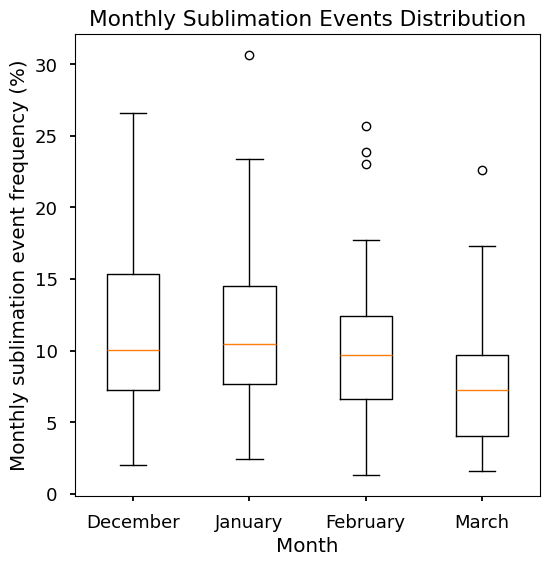

In [310]:
 # plot boxplot of monthly_results
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([monthly_results['December']*100, monthly_results['January']*100, monthly_results['February']*100, monthly_results['March']*100],
              labels=['December', 'January', 'February', 'March'])
ax.set_title('Monthly Sublimation Events Distribution')
ax.set_ylabel("Monthly sublimation event frequency (%)")
ax.set_xlabel('Month')

## Look for trends

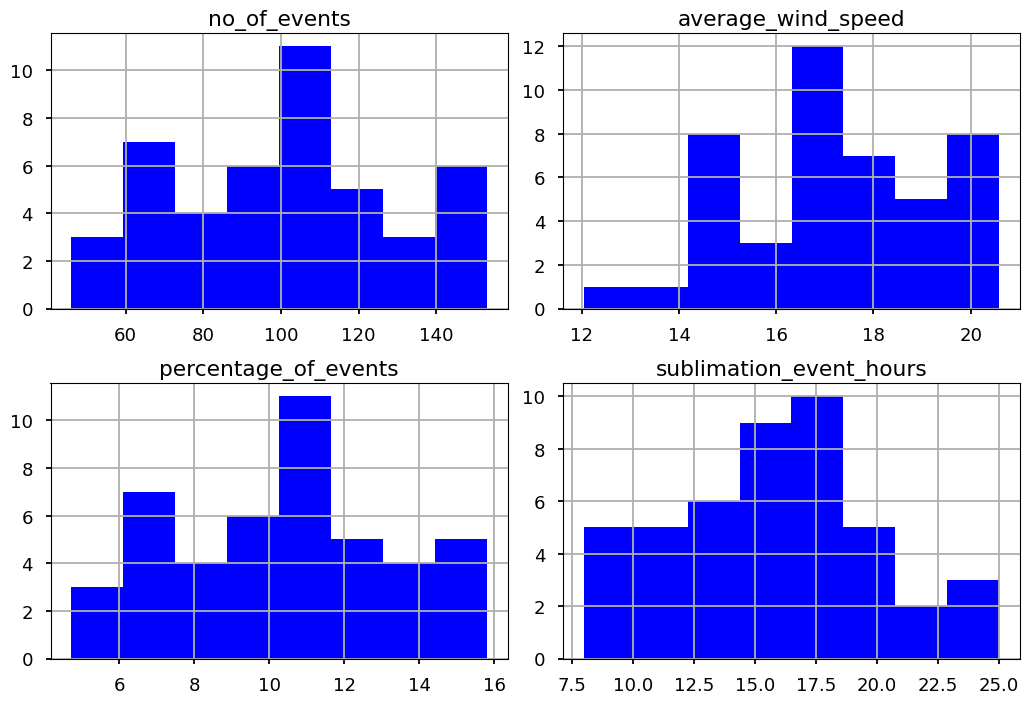

In [311]:
fig, axs = plt.subplots(2,2, tight_layout=True);
axs = axs.ravel()
cols = ['no_of_events', 'average_wind_speed', 'percentage_of_events', 'sublimation_event_hours']

for i in range(len(axs)):
    result_df[cols[i]].hist(ax=axs[i], color='blue', bins=8)
    axs[i].set_title(cols[i])

In [312]:
# perform mann-kendall test
import pymannkendall as mk
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

# perform the Mann-Kendall test
mk_result_no_events = mk.original_test(result_df['no_of_events'], alpha=0.05)
mk_gjt_obs = mk.original_test(guc_obs['winds'], alpha=0.05)
mk_result_average_windspeed = mk.original_test(result_df['average_wind_speed'], alpha=0.05)
mk_result_percentage_of_events = mk.original_test(result_df['percentage_of_events'], alpha=0.05)

print(mk_result_no_events)
print(mk_gjt_obs)
print(mk_result_average_windspeed)
print(mk_result_percentage_of_events)


Mann_Kendall_Test(trend='no trend', h=False, p=0.22477905919107233, z=1.213917946099058, Tau=0.12626262626262627, s=125.0, var_s=10434.333333333334, slope=0.3333333333333333, intercept=95.66666666666667)
Mann_Kendall_Test(trend='no trend', h=False, p=0.8970134128046536, z=0.12943505283539394, Tau=0.010323010323010324, s=31.0, var_s=53720.333333333336, slope=0.0017944541853143778, intercept=17.759218909858657)
Mann_Kendall_Test(trend='no trend', h=False, p=0.0734274676243003, z=1.7901645162429376, Tau=0.18585858585858586, s=184.0, var_s=10450.0, slope=0.042163213094075516, intercept=16.219217936197918)
Mann_Kendall_Test(trend='no trend', h=False, p=0.22482348603340796, z=1.2138016240086111, Tau=0.12626262626262627, s=125.0, var_s=10436.333333333334, slope=0.03443526170798896, intercept=9.882920110192838)
